# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
!pip install torchinfo

In [2]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output

sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")
# Нет gpu для mac на Apple Silicon, используем встроенный Metal
device = f"mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [3]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


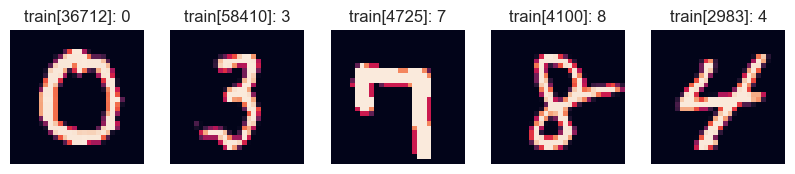

In [ ]:
train_idx1, train_idx2, train_idx3 = np.random.randint(0, 60000, 3)
val_idx1, val_idx2 = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(10, 2))
for i, idx in enumerate([train_idx1, train_idx2, train_idx3, val_idx1, val_idx2]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_dataset[idx][0].permute(1, 2, 0))
    plt.title(f"train[{idx}]: {classes[train_dataset[idx][1]]}")
    plt.axis("off")

Создайте генераторы батчей.

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(history["acc"]["train"][-1] * 100)
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(history["acc"]["val"][-1] * 100)
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, train_loss, train_acc, len(train_batch_gen), "train")

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "red", "black"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][1:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(history["loss"]["val"][1:epochs], lw=1.5, c=colors[i], ls="--")
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][1:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(history["acc"]["val"][1:epochs], lw=1.5, c=colors[i], ls="--")
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

In [ ]:
simple_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters())

history_cnn = train(
    simple_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn.state_dict(), "simple_cnn.pth")

Epoch 40 of 40 took 7.457 s
  training loss: 	0.002869
  validation loss: 	0.053953
  training accuracy: 			99.91 %
  validation accuracy: 			99.09 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

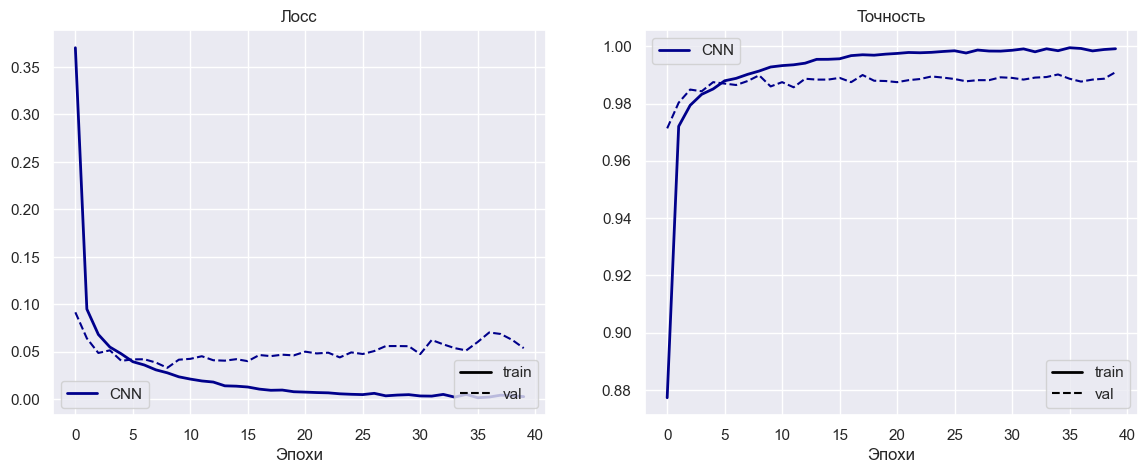

In [ ]:
plot_histories([history_cnn], ["CNN"])

Видно, что 40 эпох много - происходит переобучение. Поэтому следует, для большей наглядности на графиках качества моделей поставить меньшее число эпох. Возьмем 20, далее все сети будут обучаться 20 эпох

In [ ]:
mid_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.Sigmoid(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.Sigmoid(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=16),
    nn.Sigmoid(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mid_cnn.parameters())

history_mid_cnn = train(
    mid_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(mid_cnn.state_dict(), "mid_cnn.pth")

Epoch 40 of 40 took 7.492 s
  training loss: 	0.004890
  validation loss: 	0.044935
  training accuracy: 			99.89 %
  validation accuracy: 			98.84 %


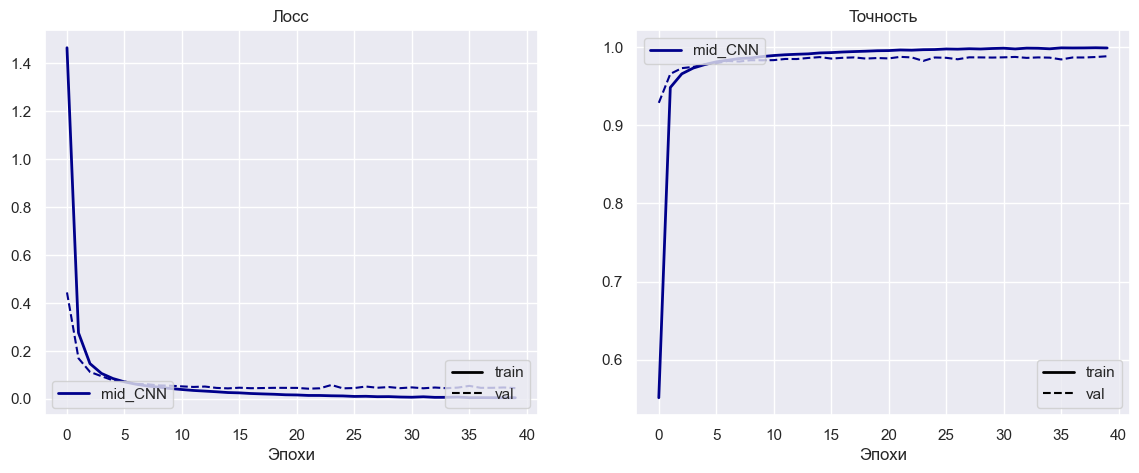

In [ ]:
plot_histories([history_mid_cnn], ["mid_CNN"])

In [ ]:
large_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.Sigmoid(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.Sigmoid(),
    nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.Sigmoid(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=16),
    nn.Sigmoid(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(large_cnn.parameters())

history_large_cnn = train(
    large_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(large_cnn.state_dict(), "large_cnn.pth")

Epoch 40 of 40 took 8.398 s
  training loss: 	0.000520
  validation loss: 	0.060939
  training accuracy: 			100.00 %
  validation accuracy: 			98.68 %


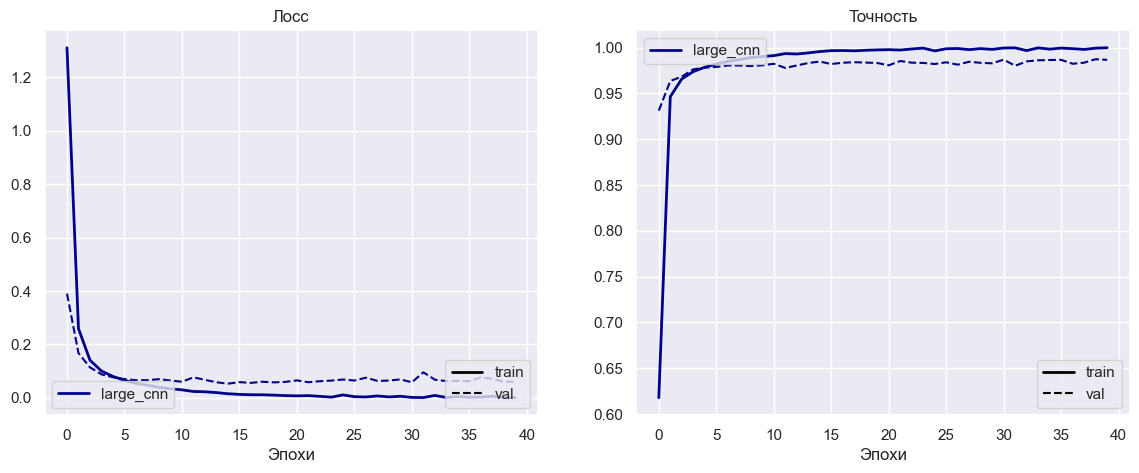

In [ ]:
plot_histories([history_large_cnn], ["large_cnn"])

In [ ]:
large_relu_cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(large_relu_cnn.parameters())

history_large_relu_cnn = train(
    large_relu_cnn,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(large_relu_cnn.state_dict(), "large_relu_cnn.pth")

Epoch 40 of 40 took 8.496 s
  training loss: 	0.004845
  validation loss: 	0.089366
  training accuracy: 			99.84 %
  validation accuracy: 			98.79 %


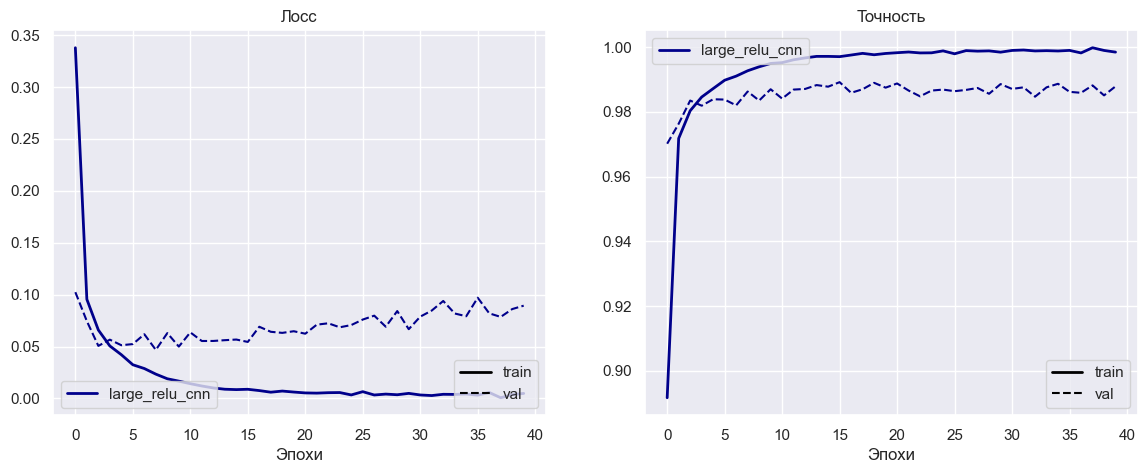

In [ ]:
plot_histories([history_large_relu_cnn], ["large_relu_cnn"])

In [ ]:
small_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2704, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters())

history_small_model_cnn = train(
    small_model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(small_model.state_dict(), "small_model.pth")

Epoch 40 of 40 took 6.608 s
  training loss: 	0.010048
  validation loss: 	0.106881
  training accuracy: 			99.72 %
  validation accuracy: 			97.70 %


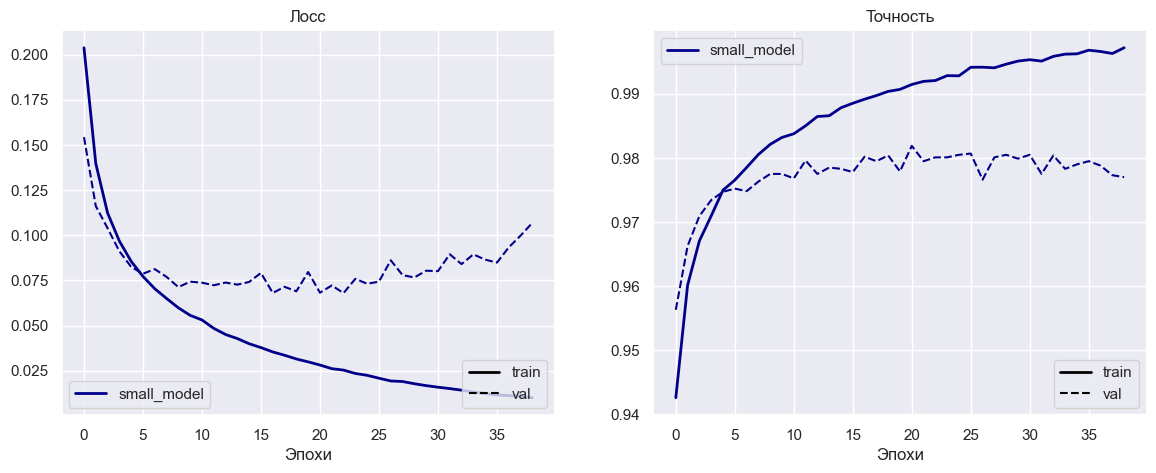

In [ ]:
plot_histories([history_small_model_cnn], ["small_model"])

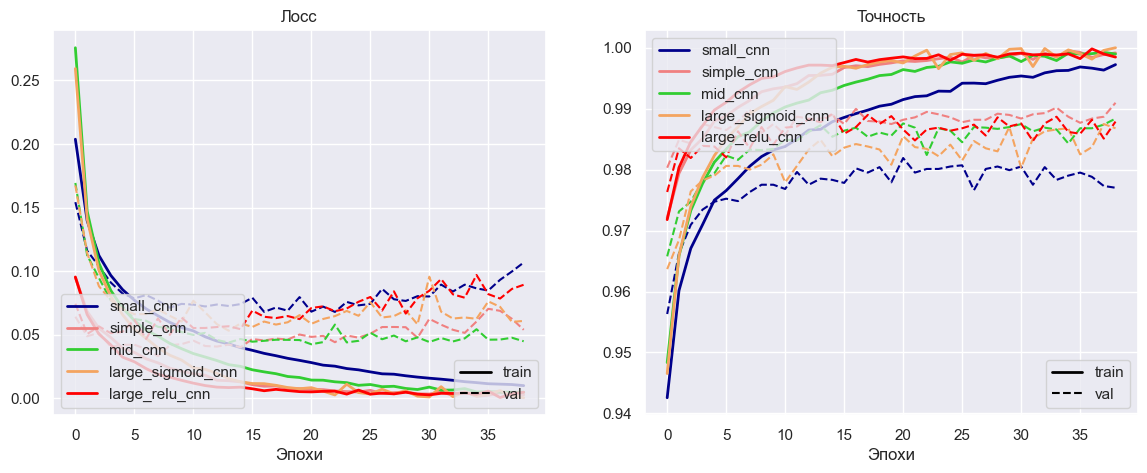

In [ ]:
plot_histories(
    [
        history_small_model_cnn,
        history_cnn,
        history_mid_cnn,
        history_large_cnn,
        history_large_relu_cnn,
    ],
    ["small_cnn", "simple_cnn", "mid_cnn", "large_sigmoid_cnn", "large_relu_cnn"],
)

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**
Ввиду простой задачи многие модели показали себя +- одинаково. Видно по графикам что модели начинают переобучаться уже на 10-15 эпохе. Лучше всего себя показала модель с семинара, спасибо за это)
Значит, количество слоев не всегда говорит о лучшем качестве, это видно на примере большйо модели с Sigmoid и ReLU. Также, совсем простые модели (С 1 конв слоев) показывают себя значительно(для этой задачи) хуже

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [ ]:
model = simple_cnn

In [ ]:
simple_cnn_33 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_33.parameters())

history_cnn_33 = train(
    simple_cnn_33,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_33.state_dict(), "simple_cnn_33.pth")

Epoch 40 of 40 took 7.785 s
  training loss: 	0.002236
  validation loss: 	0.068929
  training accuracy: 			99.93 %
  validation accuracy: 			98.80 %


In [ ]:
simple_cnn_35 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_35.parameters())

history_cnn_35 = train(
    simple_cnn_35,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_35.state_dict(), "simple_cnn_35.pth")

Epoch 40 of 40 took 7.814 s
  training loss: 	0.003285
  validation loss: 	0.073093
  training accuracy: 			99.89 %
  validation accuracy: 			98.72 %


In [ ]:
simple_cnn_53 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_53.parameters())

history_cnn_53 = train(
    simple_cnn_53,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_53.state_dict(), "simple_cnn_53.pth")

Epoch 40 of 40 took 7.477 s
  training loss: 	0.002323
  validation loss: 	0.050803
  training accuracy: 			99.92 %
  validation accuracy: 			99.22 %


In [ ]:
summary(simple_cnn_53, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 24, 24]           416
├─MaxPool2d: 1-2                         [1, 16, 12, 12]           --
├─ReLU: 1-3                              [1, 16, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 10, 10]           9,280
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 16]                   25,616
├─ReLU: 1-9                              [1, 16]                   --
├─Linear: 1-10                           [1, 10]                   170
Total params: 35,482
Trainable params: 35,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.19
Input size (MB): 0.00
Forward/backwa

In [ ]:
simple_cnn_55 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_55.parameters())

history_cnn_55 = train(
    simple_cnn_55,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_55.state_dict(), "simple_cnn_55.pth")

Epoch 40 of 40 took 7.548 s
  training loss: 	0.002603
  validation loss: 	0.055779
  training accuracy: 			99.92 %
  validation accuracy: 			99.02 %


In [ ]:
simple_cnn_99 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=9),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_99.parameters())

history_cnn_99 = train(
    simple_cnn_99,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_99.state_dict(), "simple_cnn99.pth")

Epoch 40 of 40 took 7.290 s
  training loss: 	0.000148
  validation loss: 	0.049650
  training accuracy: 			100.00 %
  validation accuracy: 			99.13 %


In [ ]:
simple_cnn_22 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn_22.parameters())

history_cnn_22 = train(
    simple_cnn_22,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40,
)
# Сохраняем веса модели в файл
torch.save(simple_cnn_22.state_dict(), "simple_cnn_22.pth")

Epoch 40 of 40 took 7.371 s
  training loss: 	0.003458
  validation loss: 	0.095444
  training accuracy: 			99.90 %
  validation accuracy: 			98.40 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

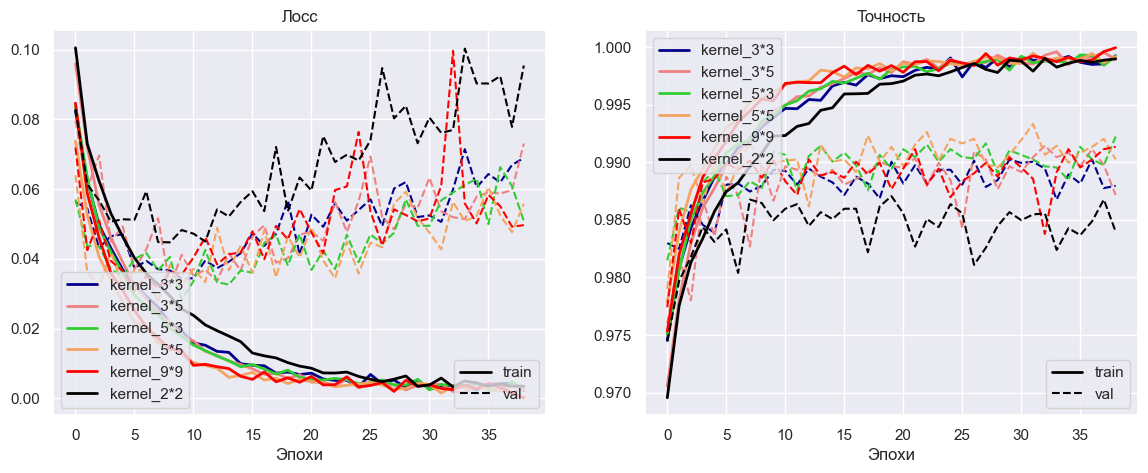

In [ ]:
plot_histories(
    [
        history_cnn_33,
        history_cnn_35,
        history_cnn_53,
        history_cnn_55,
        history_cnn_99,
        history_cnn_22,
    ],
    [
        "kernel_3*3",
        "kernel_3*5",
        "kernel_5*3",
        "kernel_5*5",
        "kernel_9*9",
        "kernel_2*2",
    ],
)

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**
Ввиду простоты задачи изменения не значительны. Однако можно сказать, что слишком большие ядра показывают не лучший результат (kernel_9*9). Наилучшее качество -- у ядер 5 на 5. Следовательно, для каждой задачи существует какой-то оптимальный размер ядра и нет смысла пытаться сделать его больше
Время обучения на gpu не зависит от размера ядер

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)
model.load_state_dict(torch.load("simple_cnn_35.pth"))
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=16, bias=True)
  (8): ReLU()
  (9): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
model = simple_cnn_35

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [7]:
accuracy = []
bad_pred = []
val_full_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=len(val_dataset), shuffle=False
)

for features, target in val_full_gen:
    features = features.to(device)
    target = target.to(device)
    predictions = model(features)
    predictions = predictions.max(1)[1].detach()
    for i in range(0, 10):
        right = predictions[(target == int(i)) & (predictions == int(i))]
        curr_accuracy = len(right) / len(target[target == int(i)])
        accuracy.append([i, curr_accuracy, len(target[target == int(i)])])

for x, y, z in accuracy:
    print(f"Class: {x}, Accuracy: {y}, Num of pictures: {z}")

Class: 0, Accuracy: 0.9918367346938776, Num of pictures: 980
Class: 1, Accuracy: 0.9929515418502203, Num of pictures: 1135
Class: 2, Accuracy: 0.9951550387596899, Num of pictures: 1032
Class: 3, Accuracy: 0.9900990099009901, Num of pictures: 1010
Class: 4, Accuracy: 0.9857433808553971, Num of pictures: 982
Class: 5, Accuracy: 0.9955156950672646, Num of pictures: 892
Class: 6, Accuracy: 0.9801670146137788, Num of pictures: 958
Class: 7, Accuracy: 0.9727626459143969, Num of pictures: 1028
Class: 8, Accuracy: 0.9866529774127311, Num of pictures: 974
Class: 9, Accuracy: 0.9801783944499505, Num of pictures: 1009


**Ответ:**
Распределение по классам картинок +- одинаковое. Однако самая низкая точность на 7, скорее всего потому что многие пишут ее похожую на 1

**Вывод по всей задаче:** 
Нейронные сети всего с 1 или 2 слоями уже могут решать такие, на первый взгляд, непростые задачи. Следует, обучать модельки на gpu)
В этой задаче мы убедились что свертки хорошо решают похожие задачи, давая высокий результат. Также, мы поняли как зависит результат от размера ядра и количества слоев 

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [2]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [3]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [4]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [7]:
from google.colab import drive

drive.mount("/content/drive")

# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/content"
style_path = "/content/drive/MyDrive/images"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.0MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=2129878712320.0000, content_loss=      0.0000, style loss=2129861280000.0000, tv loss=17378430.0000
L-BFGS | iteration: 100, total loss=1288042496.0000, content_loss=1117487500.0000, style loss=161403588.8672, tv loss=9151437.0000
L-BFGS | iteration: 200, total loss=1199837824.0000, content_loss=1049567578.1250, style loss=141822817.3828, tv loss=8447493.0000
L-BFGS | iteration: 300, total loss=1180253056.0000, content_loss=1032469140.6250, style loss=139810268.5547, tv loss=7973654.0000
L-BFGS | iteration: 400, total loss=1172101120.0000, content_loss=1025170312.5000, style loss=139256000.9766, tv loss=7674894.0000
L-BFGS | iteration: 500, total loss=1167446784.0000, content_loss=1020982519.5312, style loss=138997119.1406, tv loss=7467172.0000
L-BFGS | iteration: 600, total loss=1164349184.0000, content_loss=1018068359.3750, style loss=138970312.5000, tv loss=7310408.5000
L-BFGS | iteration: 700, total loss

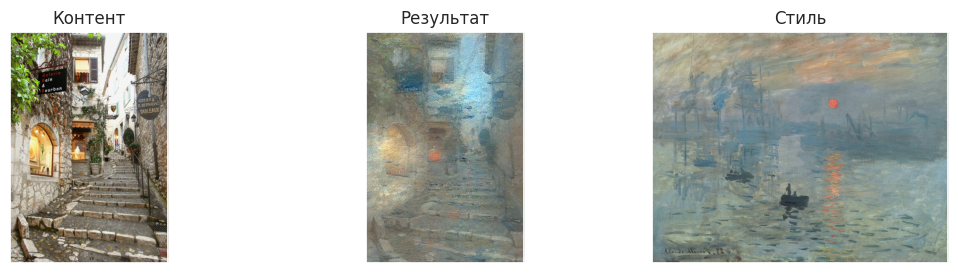

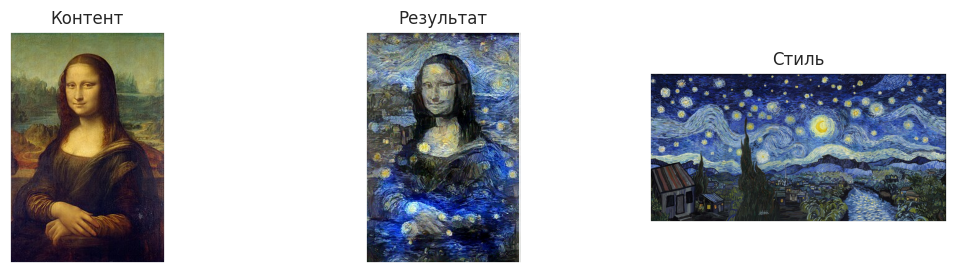

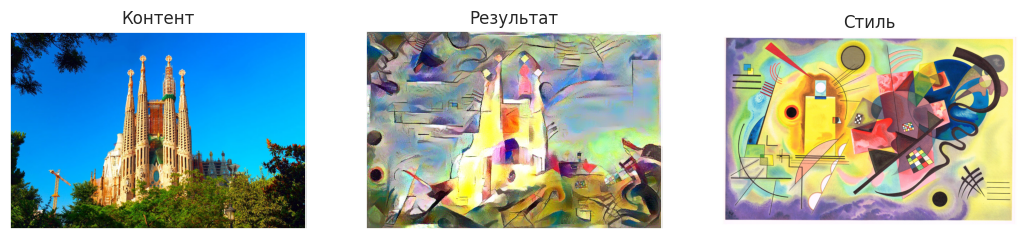

In [11]:
# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

In [10]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

Диффузионные модели

In [3]:
!pip install -q diffusers
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.4 MB/s eta 0:00:00


In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

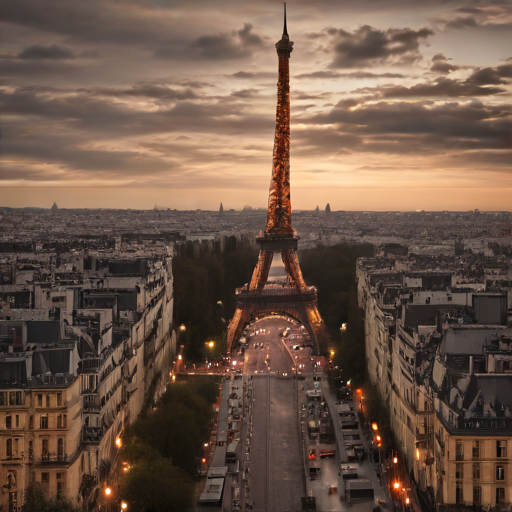

In [7]:
prompt = "Paris, with the Eiffel Tower in the background. Evening, lights, city"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

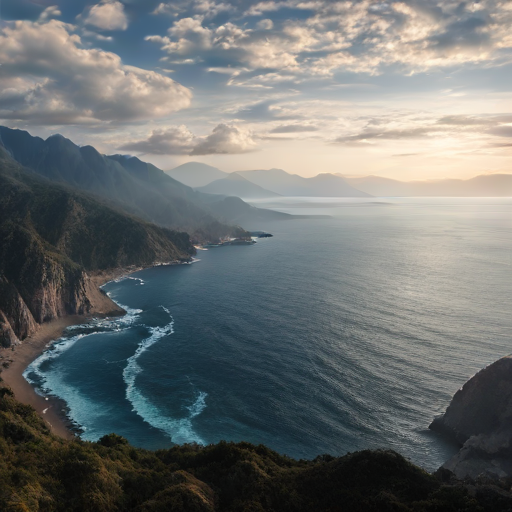

In [8]:
prompt = "Ocean near high beautiful view mountain"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

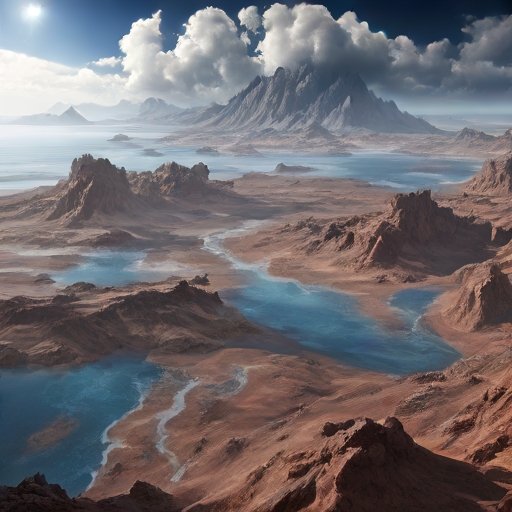

In [10]:
prompt = "Ocean near high beautiful view mountain on another planet, artstation, highly detailed"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

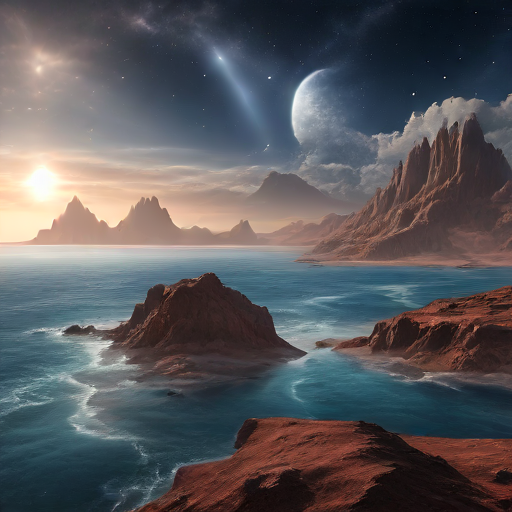

In [14]:
prompt = "Ocean near high beautiful view mountain on another planet with 2 suns, artstation, highly detailed"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
На русском языке все еще не очень хорошо генерируются картинки, поэтому стоит использовать английский)